In [1]:
# import dependencies

# for Pytorch based backbone CNN
import os
import torch
from torch import nn
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor

import numpy as np
import matplotlib.pyplot as plt

# PyTorch based flow to prepare and train a backbone CNN
########################################################
# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Split the data into Training and Validation datasets.
training_data_subset_size = int(0.8 * len(training_data))
validate_data_subset_size = len(training_data) - training_data_subset_size
training_data_subset, validation_data_subset = random_split(training_data, [training_data_subset_size, validate_data_subset_size])

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

# define batch-size to load data
batch_size = 64
# define num of epochs to be run for training
# epochs = 10
epochs = 10

# Create data loaders.
train_dataloader = DataLoader(training_data_subset, batch_size=batch_size)
validate_dataloader = DataLoader(validation_data_subset, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

100%|██████████| 26421880/26421880 [00:10<00:00, 2414913.92it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 211344.23it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3856172.88it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 23520998.90it/s]


Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64
Using cuda device


BackboneNeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (convolutional_relu_stack): Sequential(
    (0): Conv2d(1, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(256, 256, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(256, 256, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=(2, 2), stride

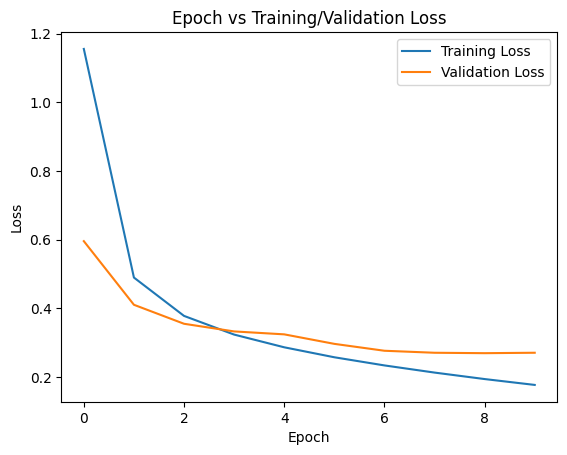

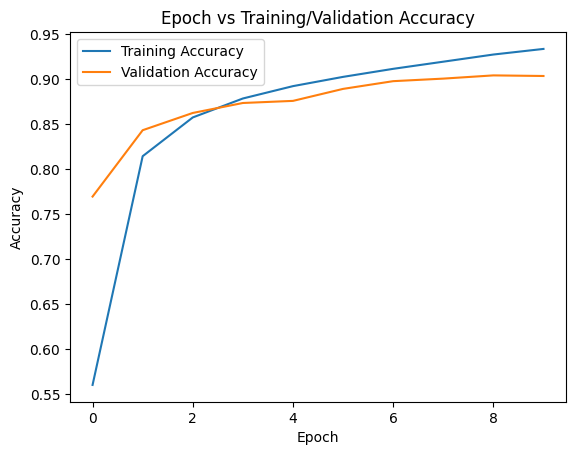

Saved PyTorch Model State to model.pth
Test Error: 
 Accuracy: 90.1%, Avg loss: 0.299253 



(0.299253318814715, 0.9006)

In [2]:
# experiment with different number of kernel in respective layers
# 1. same number of filters in each layer

##################################################
# Define backbone CNN model for feature extraction
##################################################
class BackboneNeuralNetwork(nn.Module):
    """
    Build a small CNN model consisting of 5 convolution layers. Each convolution
    layer would be followed by a ReLU activation and a max pooling layer.

    Dense network with 2 layers, with a ReLU activation after first layer. This
    layer can be used ONLY when testing CNN model in isolation. After extracting
    feature from CNN model, use MLP for classification.

    NOTE: Dense network is not used, if `backbone_only` is `True`.

    REFERENCES:
        1. https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html
        nn.Sequential()

        2. https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html#torch.nn.Conv2d
        nn.Conv2d(
            in_channels = number of layers in input images. Grayscale or monochrome images have 1 in_channels
            out_channels = number of channels in the output produced. This is a hyperparameter, which signifies the number of kernels
            kernel_size = `(m,n)` for a kernel/filter dimension, or simply n for a square (n,n) kernel/filter dimension
            stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros', device=None, dtype=None are other properties with default values
        )

        3. https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html#torch.nn.ReLU
        nn.ReLU()

        4. https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html#torch.nn.MaxPool2d
        nn.MaxPool2d(
            kernel_size = `(m,n)` for a kernel/filter dimension, or simply n for a square (n,n) kernel/filter dimension
            stride=None, padding=0, dilation=1, return_indices=False, ceil_mode=False are other properties with default values
        )

        5. https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear
        nn.Linear(
            in_features = size of each input sample
            out_features = size of each output sample
            bias=True, device=None, dtype=None are other properties with default values
        )

        6. https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html#torch.nn.Softmax
        nn.Softmax()

        7. https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
        Training a Classifier
    """

    # Constructor for the CNN Model.
    #
    # NOTE: If `backbone_only` is `True`, dense network is not used.
    def __init__(self, backbone_only=False):
        super().__init__()

        # this property helps the CNN transition from a full-fledged network to a backbone CNN
        # the default value is False - meaning an object of this class can be used to predict the labels for Fashion-MNIST dataset
        # if the value is set to True - an object of this class will return the flattened output from conv layers - thus acting as a backbone
        self.backbone_only = backbone_only

        self.flatten = nn.Flatten()

        # CNN model consisting of 5 convolution layers with each convolution
        # layer followed by a ReLU activation and a max pooling layer.
        self.convolutional_relu_stack = nn.Sequential(
            nn.Conv2d(1, 256, (3, 3), stride=(1, 1), padding=(1, 1)),    # input = (1,28,28), output = (256, 28, 28)
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),                                       # input = (256, 28, 28), output = (256, 14, 14)
            nn.Conv2d(256, 256, (3, 3), stride=(1, 1), padding=(1,1)),    # input = (256, 14, 14), output = (256, 14, 14)
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),                                       # input = (256, 14, 14), output = (256, 7, 7)
            nn.Conv2d(256, 256, (3, 3), stride=(1, 1), padding=(1,1)),   # input = (256, 7, 7), output = (256, 7, 7)
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),                                       # input = (256, 7, 7), output = (256, 3, 3)
            nn.Conv2d(256, 256, (2, 2), stride=(1, 1), padding=(1, 1)), # input = (256, 3, 3), output = (256, 4, 4)
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),                                       # input = (256, 4, 4), output = (256, 2, 2)
            nn.Conv2d(256, 256, (2, 2), stride=(1, 1), padding=(1, 1)), # input = (256, 2, 2), output = (256, 3, 3)
            nn.ReLU(),
            nn.MaxPool2d((2, 2))                                        # input = (256, 3, 3), output = (256,1,1)
        )

        # Dense network with 2 layers with a ReLU activation after first layer.
        # This layer can be used ONLY when testing CNN model in isolation.
        #
        # NOTE: Dense network is not used, if `backbone_only` is `True`.
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    # Forward pass for CNN Model
    def forward(self, x):
        # print(f'CNN Input Size: {x.size()}')
        x1 = self.convolutional_relu_stack(x)
        # print(f'CNN Output Size: {x1.size()}')
        x2 = self.flatten(x1)
        # print(f'Flatten Size: {x2.size()}')

        if self.backbone_only:  # return the flattened tensor containing feature extraction data
            return x2

        # default behaviour is to return the predicted labels
        x3 = self.linear_relu_stack(x2)
        return x3
##################################################

# create model instance
model = BackboneNeuralNetwork().to(device)
print(model)

# define loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1)

# forward pass implementation
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.train()
    aggregate_loss, aggregate_accuracy = 0.0, 0.0
    for batch, (X, y) in enumerate(dataloader):
        optimizer.zero_grad()
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)
        correct = (pred.argmax(1) == y).type(torch.float).sum()

        aggregate_loss += loss.item()
        aggregate_accuracy += correct.item()

        # Backpropagation
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    aggregate_loss /= num_batches
    aggregate_accuracy /= size
    print(f"Training Error: \n Accuracy: {(100*aggregate_accuracy):>0.1f}%, Avg loss: {aggregate_loss:>8f} \n")
    return aggregate_loss, aggregate_accuracy

# validation implementation
def validate(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    aggregate_loss, aggregate_accuracy = 0.0, 0.0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            aggregate_loss += loss_fn(pred, y).item()
            aggregate_accuracy += (pred.argmax(1) == y).type(torch.float).sum().item()
    aggregate_loss /= num_batches
    aggregate_accuracy /= size
    print(f"Validation Error: \n Accuracy: {(100*aggregate_accuracy):>0.1f}%, Avg loss: {aggregate_loss:>8f} \n")
    return aggregate_loss, aggregate_accuracy

# testing implementation
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    aggregate_loss, aggregate_accuracy = 0.0, 0.0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            aggregate_loss += loss_fn(pred, y).item()
            aggregate_accuracy += (pred.argmax(1) == y).type(torch.float).sum().item()
    aggregate_loss /= num_batches
    aggregate_accuracy /= size
    print(f"Test Error: \n Accuracy: {(100*aggregate_accuracy):>0.1f}%, Avg loss: {aggregate_loss:>8f} \n")
    return aggregate_loss, aggregate_accuracy

# capture loss and accuracy across phases to plot
train_loss, train_accuracy, valid_loss, valid_accuracy = [], [], [], []

# Train and Validate the CNN
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    epoch_train_loss, epoch_train_accuracy = train(train_dataloader, model, loss_fn, optimizer)
    train_loss.append(epoch_train_loss)
    train_accuracy.append(epoch_train_accuracy)
    epoch_valid_loss, epoch_valid_accuracy = validate(validate_dataloader, model, loss_fn)
    valid_loss.append(epoch_valid_loss)
    valid_accuracy.append(epoch_valid_accuracy)
print("Done!")

def show_plots():
    # Plot training vs validationloss
    plt.plot(train_loss, label='Training Loss')
    plt.plot(valid_loss, label='Validation Loss')
    plt.title('Epoch vs Training/Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Plot training vs validation accuracy
    plt.plot(train_accuracy, label='Training Accuracy')
    plt.plot(valid_accuracy, label='Validation Accuracy')
    plt.title('Epoch vs Training/Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

show_plots()

# Save the model
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

# Load the model to perform testing on the trained variables
model = BackboneNeuralNetwork().to(device)
model.load_state_dict(torch.load("model.pth"))

# Test with the model
test(test_dataloader, model, loss_fn)

BackboneNeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (convolutional_relu_stack): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(128, 256, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(256, 512, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=(2, 2), stride=(2,

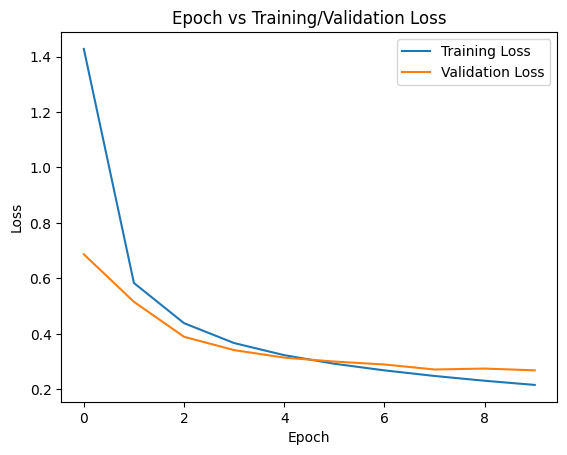

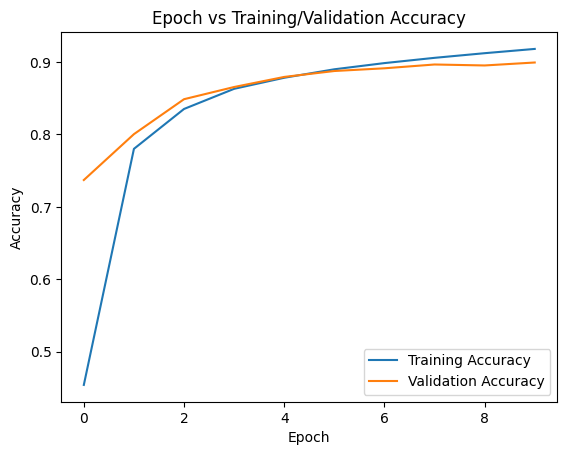

Saved PyTorch Model State to model.pth
Test Error: 
 Accuracy: 89.4%, Avg loss: 0.290769 



(0.2907690961079992, 0.8943)

In [3]:
# experiment with different number of kernel in respective layers
# 2. double the number of filters in successive layers

##################################################
# Define backbone CNN model for feature extraction
##################################################
class BackboneNeuralNetwork(nn.Module):
    """
    Build a small CNN model consisting of 5 convolution layers. Each convolution
    layer would be followed by a ReLU activation and a max pooling layer.

    Dense network with 2 layers, with a ReLU activation after first layer. This
    layer can be used ONLY when testing CNN model in isolation. After extracting
    feature from CNN model, use MLP for classification.

    NOTE: Dense network is not used, if `backbone_only` is `True`.

    REFERENCES:
        1. https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html
        nn.Sequential()

        2. https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html#torch.nn.Conv2d
        nn.Conv2d(
            in_channels = number of layers in input images. Grayscale or monochrome images have 1 in_channels
            out_channels = number of channels in the output produced. This is a hyperparameter, which signifies the number of kernels
            kernel_size = `(m,n)` for a kernel/filter dimension, or simply n for a square (n,n) kernel/filter dimension
            stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros', device=None, dtype=None are other properties with default values
        )

        3. https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html#torch.nn.ReLU
        nn.ReLU()

        4. https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html#torch.nn.MaxPool2d
        nn.MaxPool2d(
            kernel_size = `(m,n)` for a kernel/filter dimension, or simply n for a square (n,n) kernel/filter dimension
            stride=None, padding=0, dilation=1, return_indices=False, ceil_mode=False are other properties with default values
        )

        5. https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear
        nn.Linear(
            in_features = size of each input sample
            out_features = size of each output sample
            bias=True, device=None, dtype=None are other properties with default values
        )

        6. https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html#torch.nn.Softmax
        nn.Softmax()

        7. https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
        Training a Classifier
    """

    # Constructor for the CNN Model.
    #
    # NOTE: If `backbone_only` is `True`, dense network is not used.
    def __init__(self, backbone_only=False):
        super().__init__()

        # this property helps the CNN transition from a full-fledged network to a backbone CNN
        # the default value is False - meaning an object of this class can be used to predict the labels for Fashion-MNIST dataset
        # if the value is set to True - an object of this class will return the flattened output from conv layers - thus acting as a backbone
        self.backbone_only = backbone_only

        self.flatten = nn.Flatten()

        # CNN model consisting of 5 convolution layers with each convolution
        # layer followed by a ReLU activation and a max pooling layer.
        self.convolutional_relu_stack = nn.Sequential(
            nn.Conv2d(1, 32, (3, 3), stride=(1, 1), padding=(1, 1)),    # input = (1,28,28), output = (32, 28, 28)
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),                                       # input = (32, 28, 28), output = (32, 14, 14)
            nn.Conv2d(32, 64, (3, 3), stride=(1, 1), padding=(1,1)),    # input = (32, 14, 14), output = (64, 14, 14)
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),                                       # input = (64, 14, 14), output = (64, 7, 7)
            nn.Conv2d(64, 128, (3, 3), stride=(1, 1), padding=(1,1)),   # input = (64, 7, 7), output = (128, 7, 7)
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),                                       # input = (128, 7, 7), output = (128, 3, 3)
            nn.Conv2d(128, 256, (2, 2), stride=(1, 1), padding=(1, 1)), # input = (128, 3, 3), output = (256, 4, 4)
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),                                       # input = (256, 4, 4), output = (256, 2, 2)
            nn.Conv2d(256, 512, (2, 2), stride=(1, 1), padding=(1, 1)), # input = (256, 2, 2), output = (512, 3, 3)
            nn.ReLU(),
            nn.MaxPool2d((2, 2))                                        # input = (512, 3, 3), output = (512,1,1)
        )

        # Dense network with 2 layers with a ReLU activation after first layer.
        # This layer can be used ONLY when testing CNN model in isolation.
        #
        # NOTE: Dense network is not used, if `backbone_only` is `True`.
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    # Forward pass for CNN Model
    def forward(self, x):
        # print(f'CNN Input Size: {x.size()}')
        x1 = self.convolutional_relu_stack(x)
        # print(f'CNN Output Size: {x1.size()}')
        x2 = self.flatten(x1)
        # print(f'Flatten Size: {x2.size()}')

        if self.backbone_only:  # return the flattened tensor containing feature extraction data
            return x2

        # default behaviour is to return the predicted labels
        x3 = self.linear_relu_stack(x2)
        return x3
##################################################

# create model instance
model = BackboneNeuralNetwork().to(device)
print(model)

# define loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1)

# forward pass implementation
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.train()
    aggregate_loss, aggregate_accuracy = 0.0, 0.0
    for batch, (X, y) in enumerate(dataloader):
        optimizer.zero_grad()
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)
        correct = (pred.argmax(1) == y).type(torch.float).sum()

        aggregate_loss += loss.item()
        aggregate_accuracy += correct.item()

        # Backpropagation
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    aggregate_loss /= num_batches
    aggregate_accuracy /= size
    print(f"Training Error: \n Accuracy: {(100*aggregate_accuracy):>0.1f}%, Avg loss: {aggregate_loss:>8f} \n")
    return aggregate_loss, aggregate_accuracy

# validation implementation
def validate(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    aggregate_loss, aggregate_accuracy = 0.0, 0.0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            aggregate_loss += loss_fn(pred, y).item()
            aggregate_accuracy += (pred.argmax(1) == y).type(torch.float).sum().item()
    aggregate_loss /= num_batches
    aggregate_accuracy /= size
    print(f"Validation Error: \n Accuracy: {(100*aggregate_accuracy):>0.1f}%, Avg loss: {aggregate_loss:>8f} \n")
    return aggregate_loss, aggregate_accuracy

# testing implementation
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    aggregate_loss, aggregate_accuracy = 0.0, 0.0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            aggregate_loss += loss_fn(pred, y).item()
            aggregate_accuracy += (pred.argmax(1) == y).type(torch.float).sum().item()
    aggregate_loss /= num_batches
    aggregate_accuracy /= size
    print(f"Test Error: \n Accuracy: {(100*aggregate_accuracy):>0.1f}%, Avg loss: {aggregate_loss:>8f} \n")
    return aggregate_loss, aggregate_accuracy

# capture loss and accuracy across phases to plot
train_loss, train_accuracy, valid_loss, valid_accuracy = [], [], [], []

# Train and Validate the CNN
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    epoch_train_loss, epoch_train_accuracy = train(train_dataloader, model, loss_fn, optimizer)
    train_loss.append(epoch_train_loss)
    train_accuracy.append(epoch_train_accuracy)
    epoch_valid_loss, epoch_valid_accuracy = validate(validate_dataloader, model, loss_fn)
    valid_loss.append(epoch_valid_loss)
    valid_accuracy.append(epoch_valid_accuracy)
print("Done!")

def show_plots():
    # Plot training vs validationloss
    plt.plot(train_loss, label='Training Loss')
    plt.plot(valid_loss, label='Validation Loss')
    plt.title('Epoch vs Training/Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Plot training vs validation accuracy
    plt.plot(train_accuracy, label='Training Accuracy')
    plt.plot(valid_accuracy, label='Validation Accuracy')
    plt.title('Epoch vs Training/Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

show_plots()

# Save the model
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

# Load the model to perform testing on the trained variables
model = BackboneNeuralNetwork().to(device)
model.load_state_dict(torch.load("model.pth"))

# Test with the model
test(test_dataloader, model, loss_fn)

BackboneNeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (convolutional_relu_stack): Sequential(
    (0): Conv2d(1, 49, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(49, 98, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(98, 196, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(196, 392, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(392, 784, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=(2, 2), stride=(2,

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


Validation Error: 
 Accuracy: 75.8%, Avg loss: 0.643329 

Epoch 2
-------------------------------
loss: 0.556307  [   64/48000]
loss: 0.537199  [ 6464/48000]
loss: 0.804243  [12864/48000]
loss: 0.435284  [19264/48000]
loss: 0.483843  [25664/48000]
loss: 0.549952  [32064/48000]
loss: 0.445827  [38464/48000]
loss: 0.415535  [44864/48000]
Training Error: 
 Accuracy: 78.2%, Avg loss: 0.573381 

Validation Error: 
 Accuracy: 82.1%, Avg loss: 0.476231 

Epoch 3
-------------------------------
loss: 0.313578  [   64/48000]
loss: 0.398873  [ 6464/48000]
loss: 0.692850  [12864/48000]
loss: 0.339884  [19264/48000]
loss: 0.345519  [25664/48000]
loss: 0.506528  [32064/48000]
loss: 0.382588  [38464/48000]
loss: 0.375451  [44864/48000]
Training Error: 
 Accuracy: 83.0%, Avg loss: 0.450989 

Validation Error: 
 Accuracy: 84.6%, Avg loss: 0.401540 

Epoch 4
-------------------------------
loss: 0.240919  [   64/48000]
loss: 0.430998  [ 6464/48000]
loss: 0.558143  [12864/48000]
loss: 0.298677  [19264/4

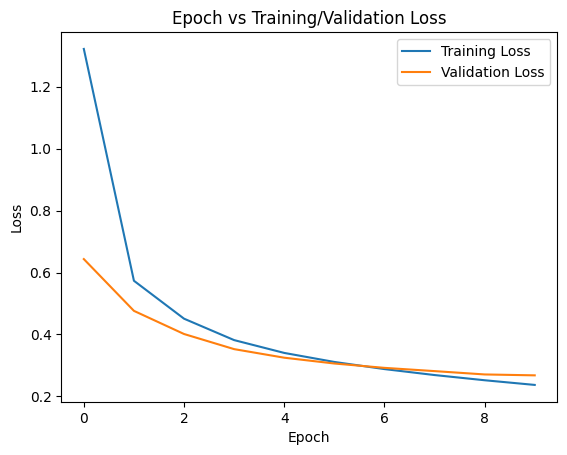

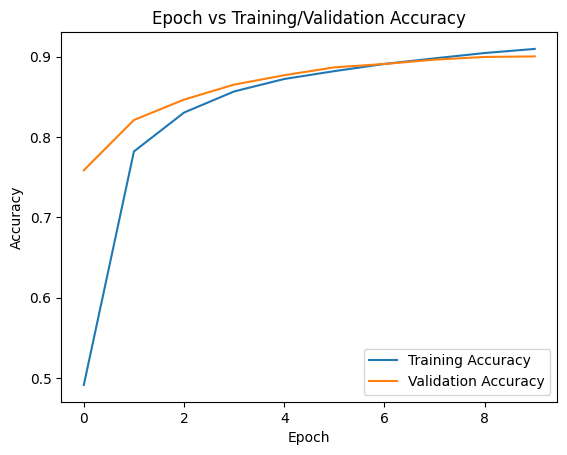

Saved PyTorch Model State to model.pth
Test Error: 
 Accuracy: 89.2%, Avg loss: 0.293090 



(0.2930903803960533, 0.8922)

In [5]:
# # experiment with different kernel size -- (3,3) in first layer, (2,2) in next four layers

# ==========================================================
# Define Backbone CNN Model for Feature Extraction
# ==========================================================

class BackboneNeuralNetwork(nn.Module):
    """
    Build a small CNN model consisting of 5 convolution layers. Each convolution
    layer would be followed by a ReLU activation and a max pooling layer.

    Dense network with 2 layers, with a ReLU activation after first layer. This
    layer can be used ONLY when testing CNN model in isolation. After extracting
    feature from CNN model, use MLP for classification.

    NOTE: Dense network is not used, if `backbone_only` is `True`.

    REFERENCES:
        1. https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html
        nn.Sequential()

        2. https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html#torch.nn.Conv2d
        nn.Conv2d(
            in_channels = number of layers in input images. Grayscale or monochrome images have 1 in_channels
            out_channels = number of channels in the output produced. This is a hyperparameter, which signifies the number of kernels
            kernel_size = `(m,n)` for a kernel/filter dimension, or simply n for a square (n,n) kernel/filter dimension
            stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros', device=None, dtype=None are other properties with default values
        )

        3. https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html#torch.nn.ReLU
        nn.ReLU()

        4. https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html#torch.nn.MaxPool2d
        nn.MaxPool2d(
            kernel_size = `(m,n)` for a kernel/filter dimension, or simply n for a square (n,n) kernel/filter dimension
            stride=None, padding=0, dilation=1, return_indices=False, ceil_mode=False are other properties with default values
        )

        5. https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear
        nn.Linear(
            in_features = size of each input sample
            out_features = size of each output sample
            bias=True, device=None, dtype=None are other properties with default values
        )

        6. https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html#torch.nn.Softmax
        nn.Softmax()

        7. https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
        Training a Classifier
    """

    # Constructor for the CNN Model.
    #
    # NOTE: If `backbone_only` is `True`, dense network is not used.
    def __init__(self, backbone_only=False):
        super().__init__()

        # this property helps the CNN transition from a full-fledged network to a backbone CNN
        # the default value is False - meaning an object of this class can be used to predict the labels for Fashion-MNIST dataset
        # if the value is set to True - an object of this class will return the flattened output from conv layers - thus acting as a backbone
        self.backbone_only = backbone_only

        self.flatten = nn.Flatten()

        # CNN model consisting of 5 convolution layers with each convolution
        # layer followed by a ReLU activation and a max pooling layer.
        self.convolutional_relu_stack = nn.Sequential(
            nn.Conv2d(1, 49, (3, 3), stride=(1, 1), padding=(1, 1)),    # input = (1,28,28), output = (49, 28, 28)
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),                                       # input = (49, 28, 28), output = (49, 14, 14)
            nn.Conv2d(49, 98, (2, 2), stride=(1, 1), padding=(1,1)),    # input = (49, 14, 14), output = (98, 15, 15)
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),                                       # input = (98, 15, 15), output = (98, 7, 7)
            nn.Conv2d(98, 196, (2, 2), stride=(1, 1), padding=(1,1)),   # input = (98, 7, 7), output = (196, 8, 8)
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),                                       # input = (196, 8, 8), output = (196, 4, 4)
            nn.Conv2d(196, 392, (2, 2), stride=(1, 1), padding=(1, 1)), # input = (196, 4, 4), output = (392, 5, 5)
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),                                       # input = (392, 5, 5), output = (392, 2, 2)
            nn.Conv2d(392, 784, (2, 2), stride=(1, 1), padding=(1, 1)), # input = (392, 2, 2), output = (784, 3, 3)
            nn.ReLU(),
            nn.MaxPool2d((2, 2))                                        # input = (784, 3, 3), output = (784,1,1)
        )

        # Dense network with 2 layers with a ReLU activation after first layer.
        # This layer can be used ONLY when testing CNN model in isolation.
        #
        # NOTE: Dense network is not used, if `backbone_only` is `True`.
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(784, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    # Forward pass for CNN Model
    def forward(self, x):
        # logger.debug(f'CNN Input Size: {x.size()}')
        x1 = self.convolutional_relu_stack(x)
        # logger.debug(f'CNN Output Size: {x1.size()}')
        x2 = self.flatten(x1)
        # logger.debug(f'Flatten Size: {x2.size()}')

        if self.backbone_only:  # return the flattened tensor containing feature extraction data
            return x2

        # default behaviour is to return the predicted labels
        x3 = self.linear_relu_stack(x2)
        return x3
##################################################

# create model instance
model = BackboneNeuralNetwork().to(device)
print(model)

# define loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1)

# forward pass implementation
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.train()
    aggregate_loss, aggregate_accuracy = 0.0, 0.0
    for batch, (X, y) in enumerate(dataloader):
        optimizer.zero_grad()
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)
        correct = (pred.argmax(1) == y).type(torch.float).sum()

        aggregate_loss += loss.item()
        aggregate_accuracy += correct.item()

        # Backpropagation
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    aggregate_loss /= num_batches
    aggregate_accuracy /= size
    print(f"Training Error: \n Accuracy: {(100*aggregate_accuracy):>0.1f}%, Avg loss: {aggregate_loss:>8f} \n")
    return aggregate_loss, aggregate_accuracy

# validation implementation
def validate(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    aggregate_loss, aggregate_accuracy = 0.0, 0.0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            aggregate_loss += loss_fn(pred, y).item()
            aggregate_accuracy += (pred.argmax(1) == y).type(torch.float).sum().item()
    aggregate_loss /= num_batches
    aggregate_accuracy /= size
    print(f"Validation Error: \n Accuracy: {(100*aggregate_accuracy):>0.1f}%, Avg loss: {aggregate_loss:>8f} \n")
    return aggregate_loss, aggregate_accuracy

# testing implementation
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    aggregate_loss, aggregate_accuracy = 0.0, 0.0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            aggregate_loss += loss_fn(pred, y).item()
            aggregate_accuracy += (pred.argmax(1) == y).type(torch.float).sum().item()
    aggregate_loss /= num_batches
    aggregate_accuracy /= size
    print(f"Test Error: \n Accuracy: {(100*aggregate_accuracy):>0.1f}%, Avg loss: {aggregate_loss:>8f} \n")
    return aggregate_loss, aggregate_accuracy

# capture loss and accuracy across phases to plot
train_loss, train_accuracy, valid_loss, valid_accuracy = [], [], [], []

# Train and Validate the CNN
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    epoch_train_loss, epoch_train_accuracy = train(train_dataloader, model, loss_fn, optimizer)
    train_loss.append(epoch_train_loss)
    train_accuracy.append(epoch_train_accuracy)
    epoch_valid_loss, epoch_valid_accuracy = validate(validate_dataloader, model, loss_fn)
    valid_loss.append(epoch_valid_loss)
    valid_accuracy.append(epoch_valid_accuracy)
print("Done!")

def show_plots():
    # Plot training vs validationloss
    plt.plot(train_loss, label='Training Loss')
    plt.plot(valid_loss, label='Validation Loss')
    plt.title('Epoch vs Training/Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Plot training vs validation accuracy
    plt.plot(train_accuracy, label='Training Accuracy')
    plt.plot(valid_accuracy, label='Validation Accuracy')
    plt.title('Epoch vs Training/Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

show_plots()

# Save the model
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

# Load the model to perform testing on the trained variables
model = BackboneNeuralNetwork().to(device)
model.load_state_dict(torch.load("model.pth"))

# Test with the model
test(test_dataloader, model, loss_fn)

BackboneNeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (convolutional_relu_stack): Sequential(
    (0): Conv2d(1, 49, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(49, 98, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(98, 196, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(196, 392, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(392, 784, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=(2, 2), stride=(2,

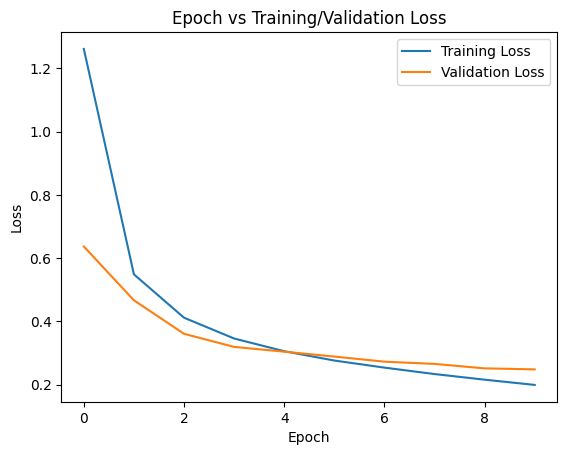

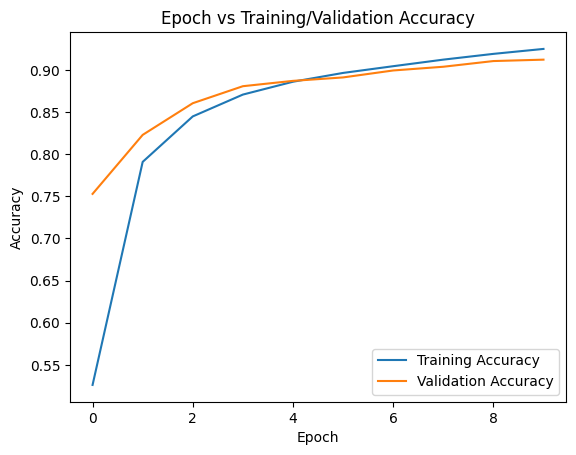

Saved PyTorch Model State to model.pth
Test Error: 
 Accuracy: 90.4%, Avg loss: 0.274256 



(0.27425576347833985, 0.904)

In [6]:
# experiment with different kernel size -- (3,3) in first three layers, (2,2) in next two layers

##################################################
# Define backbone CNN model for feature extraction
##################################################
class BackboneNeuralNetwork(nn.Module):
    """
    Build a small CNN model consisting of 5 convolution layers. Each convolution
    layer would be followed by a ReLU activation and a max pooling layer.

    Dense network with 2 layers, with a ReLU activation after first layer. This
    layer can be used ONLY when testing CNN model in isolation. After extracting
    feature from CNN model, use MLP for classification.

    NOTE: Dense network is not used, if `backbone_only` is `True`.

    REFERENCES:
        1. https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html
        nn.Sequential()

        2. https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html#torch.nn.Conv2d
        nn.Conv2d(
            in_channels = number of layers in input images. Grayscale or monochrome images have 1 in_channels
            out_channels = number of channels in the output produced. This is a hyperparameter, which signifies the number of kernels
            kernel_size = `(m,n)` for a kernel/filter dimension, or simply n for a square (n,n) kernel/filter dimension
            stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros', device=None, dtype=None are other properties with default values
        )

        3. https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html#torch.nn.ReLU
        nn.ReLU()

        4. https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html#torch.nn.MaxPool2d
        nn.MaxPool2d(
            kernel_size = `(m,n)` for a kernel/filter dimension, or simply n for a square (n,n) kernel/filter dimension
            stride=None, padding=0, dilation=1, return_indices=False, ceil_mode=False are other properties with default values
        )

        5. https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear
        nn.Linear(
            in_features = size of each input sample
            out_features = size of each output sample
            bias=True, device=None, dtype=None are other properties with default values
        )

        6. https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html#torch.nn.Softmax
        nn.Softmax()

        7. https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
        Training a Classifier
    """

    # Constructor for the CNN Model.
    #
    # NOTE: If `backbone_only` is `True`, dense network is not used.
    def __init__(self, backbone_only=False):
        super().__init__()

        # this property helps the CNN transition from a full-fledged network to a backbone CNN
        # the default value is False - meaning an object of this class can be used to predict the labels for Fashion-MNIST dataset
        # if the value is set to True - an object of this class will return the flattened output from conv layers - thus acting as a backbone
        self.backbone_only = backbone_only

        self.flatten = nn.Flatten()

        # CNN model consisting of 5 convolution layers with each convolution
        # layer followed by a ReLU activation and a max pooling layer.
        self.convolutional_relu_stack = nn.Sequential(
            nn.Conv2d(1, 49, (3, 3), stride=(1, 1), padding=(1, 1)),    # input = (1,28,28), output = (49, 28, 28)
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),                                       # input = (49, 28, 28), output = (49, 14, 14)
            nn.Conv2d(49, 98, (3, 3), stride=(1, 1), padding=(1,1)),    # input = (49, 14, 14), output = (98, 14, 14)
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),                                       # input = (98, 14, 14), output = (98, 7, 7)
            nn.Conv2d(98, 196, (3, 3), stride=(1, 1), padding=(1,1)),   # input = (98, 7, 7), output = (196, 7, 7)
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),                                       # input = (196, 7, 7), output = (196, 3, 3)
            nn.Conv2d(196, 392, (2, 2), stride=(1, 1), padding=(1, 1)), # input = (196, 3, 3), output = (392, 4, 4)
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),                                       # input = (392, 4, 4), output = (392, 2, 2)
            nn.Conv2d(392, 784, (2, 2), stride=(1, 1), padding=(1, 1)), # input = (392, 2, 2), output = (784, 3, 3)
            nn.ReLU(),
            nn.MaxPool2d((2, 2))                                        # input = (784, 3, 3), output = (784,1,1)
        )

        # Dense network with 2 layers with a ReLU activation after first layer.
        # This layer can be used ONLY when testing CNN model in isolation.
        #
        # NOTE: Dense network is not used, if `backbone_only` is `True`.
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(784, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    # Forward pass for CNN Model
    def forward(self, x):
        # print(f'CNN Input Size: {x.size()}')
        x1 = self.convolutional_relu_stack(x)
        # print(f'CNN Output Size: {x1.size()}')
        x2 = self.flatten(x1)
        # print(f'Flatten Size: {x2.size()}')

        if self.backbone_only:  # return the flattened tensor containing feature extraction data
            return x2

        # default behaviour is to return the predicted labels
        x3 = self.linear_relu_stack(x2)
        return x3
##################################################

# create model instance
model = BackboneNeuralNetwork().to(device)
print(model)

# define loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1)

# forward pass implementation
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.train()
    aggregate_loss, aggregate_accuracy = 0.0, 0.0
    for batch, (X, y) in enumerate(dataloader):
        optimizer.zero_grad()
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)
        correct = (pred.argmax(1) == y).type(torch.float).sum()

        aggregate_loss += loss.item()
        aggregate_accuracy += correct.item()

        # Backpropagation
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    aggregate_loss /= num_batches
    aggregate_accuracy /= size
    print(f"Training Error: \n Accuracy: {(100*aggregate_accuracy):>0.1f}%, Avg loss: {aggregate_loss:>8f} \n")
    return aggregate_loss, aggregate_accuracy

# validation implementation
def validate(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    aggregate_loss, aggregate_accuracy = 0.0, 0.0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            aggregate_loss += loss_fn(pred, y).item()
            aggregate_accuracy += (pred.argmax(1) == y).type(torch.float).sum().item()
    aggregate_loss /= num_batches
    aggregate_accuracy /= size
    print(f"Validation Error: \n Accuracy: {(100*aggregate_accuracy):>0.1f}%, Avg loss: {aggregate_loss:>8f} \n")
    return aggregate_loss, aggregate_accuracy

# testing implementation
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    aggregate_loss, aggregate_accuracy = 0.0, 0.0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            aggregate_loss += loss_fn(pred, y).item()
            aggregate_accuracy += (pred.argmax(1) == y).type(torch.float).sum().item()
    aggregate_loss /= num_batches
    aggregate_accuracy /= size
    print(f"Test Error: \n Accuracy: {(100*aggregate_accuracy):>0.1f}%, Avg loss: {aggregate_loss:>8f} \n")
    return aggregate_loss, aggregate_accuracy

# capture loss and accuracy across phases to plot
train_loss, train_accuracy, valid_loss, valid_accuracy = [], [], [], []

# Train and Validate the CNN
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    epoch_train_loss, epoch_train_accuracy = train(train_dataloader, model, loss_fn, optimizer)
    train_loss.append(epoch_train_loss)
    train_accuracy.append(epoch_train_accuracy)
    epoch_valid_loss, epoch_valid_accuracy = validate(validate_dataloader, model, loss_fn)
    valid_loss.append(epoch_valid_loss)
    valid_accuracy.append(epoch_valid_accuracy)
print("Done!")

def show_plots():
    # Plot training vs validationloss
    plt.plot(train_loss, label='Training Loss')
    plt.plot(valid_loss, label='Validation Loss')
    plt.title('Epoch vs Training/Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Plot training vs validation accuracy
    plt.plot(train_accuracy, label='Training Accuracy')
    plt.plot(valid_accuracy, label='Validation Accuracy')
    plt.title('Epoch vs Training/Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

show_plots()

# Save the model
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

# Load the model to perform testing on the trained variables
model = BackboneNeuralNetwork().to(device)
model.load_state_dict(torch.load("model.pth"))

# Test with the model
test(test_dataloader, model, loss_fn)